In [20]:
import math, random
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

In [231]:
class Environment:
    def __init__(self, image_fp=None):
        self.data = 1
        if image_fp:
            self.reset(image_fp)
        else:
            print "WARNING: No source image provided, before using environment"
            print "please initialize using reset(String image_filepath)"
    
    # - - - - - - - - - - - - - - - -
    # SETUP
    # - - - - - - - - - - - - - - - -
    
    #Reset function - wrapper for all setup functions
    def reset(self, fp):
        try:
            self.loadSource(fp, True)
            h,w = self.source.shape[:2]
            self.resize( w, h )
            self.initCanvas()
            self.initBrush()
            self.setBrushOpacity()
            self.setRewardBlur()
            
            print "Succesfully loaded image at %s" %(fp)
            print "New canvas size = (%d, %d)" %(w,h)
        except:
            print "ERROR: Failed to load image at %s" %(fp)
    
    #Load source/reference image
    def loadSource(self, image_fp, grey=False):
        self.source = ndimage.imread(image_fp, flatten=grey)
    
    #Resize function to updated canvas dimensions
    #Must match input image dimensions
    def resize(self, w, h):
        self.width = w
        self.height = h
    
    #Initializes "blank" canvas numpy array
    def initCanvas(self):
        self.canvas = np.zeros( (self.height,self.width) )
    
    #Initialize stroke position numpy array
    def initBrush(self):
        #blank canvas
        self.brush = np.zeros( (self.height, self.width) )
        #chose random start position
        x_pos = int( random.random() * self.width-1 )
        y_pos = int( random.random() * self.height-1 )
        #flip "pixel" at brush position
        self.brush[y_pos, x_pos] = 255
    
    #Set brush opacity, input range( 0.0 to 1.0 )
    def setBrushOpacity(self, x=0.25):
        if x < 0 or x > 1:
            print "ERROR: Stroke opacity must be between 0.0 and 1.0"
        else:
            self.stroke = int(x*255)
    
    # - - - - - - - - - - - - - - - -
    # DEBUG / VISUALIZE
    # - - - - - - - - - - - - - - - -
    
    #Display function
    def display(self, n):
        plt.imshow( n )
        plt.axis('off')
        plt.show()
    
    #Invert array
    def invert(self, n):
        return 255-n
    
    #Display current source image
    def showSource(self):
        self.display( self.source )
    
    #Display current canvas
    def showCanvas(self):
        self.display( self.invert(self.canvas) )
    
    #Display current brush position
    def showBrush(self):
        self.display( self.invert(self.brush) )
        h,w = np.argwhere(self.brush>0)[0]
        print "Brush at (%d, %d)" %(w,h)
    
    #Display entire state (source, canvas, brush)
    def showAll(self):
        self.showSource()
        self.showCanvas()
        self.showBrush()
    
    # - - - - - - - - - - - - - - - -
    # UPDATE STATE
    # - - - - - - - - - - - - - - - -
    
    # Make stroke
    # Actions are provided as a tuple (x,y,b)
    # x: change in x-axis
    # y: change in y-axis
    # b: brush off/on (0,1)
    def update(self, action):
        #get current position
        pos = np.argwhere(self.brush>0)[0]
        #update canvas
        newPos = self.applyStroke(pos, action)
        #update brush position
        self.updateBrush( newPos )
    
    def applyStroke(self, start, step):
        #get positions to apply stroke to
        y1 = start[0]+step[1]
        x1 = start[1]+step[0]
        #print start[1],start[0],x1,y1,self.width,self.height
        rows,cols = self.bresenham(start[1],start[0],x1,y1,self.width,self.height)
        
        if step[2] == 1:
            #apply stroke
            try:
                self.canvas[rows,cols] += self.stroke
                self.canvas = np.clip(self.canvas, 0, 255)
            except:
                print "ERROR - Painting out-of-bounds"
            
        #return ending position of stroke
        if len(rows) == 0:
            return start[:2]
        elif rows[0] == start[0] and cols[0] == start[1]:
            i = 1
            while rows[-i] >= self.height or cols[-i] >= self.width:
                i += 1
            return [ rows[-i], cols[-i] ]
        else:
            i = 0
            while rows[-i] >= self.height or cols[-i] >= self.width:
                i += 1
            return [ rows[i], cols[i] ]
    
    #Bresenham's Line Algorithm
    def bresenham(self, x0, y0, x1, y1, w_max=0, h_max=0):
        rows, cols = [],[]
        if x0>x1:
            x_max = int(x0)
            y_max = int(y0)
            x_min = int(x1)
            y_min = int(y1)
        else:
            x_max = int(x1)
            y_max = int(y1)
            x_min = int(x0)
            y_min = int(y0)
        
        dx = x_max - x_min
        dy = y_max - y_min
        
        #exception for vertical lines
        if dx == 0:
            for y in range(y_min, y_max):
                rows.append(y)
                cols.append(x_min)
            return rows,cols
        
        error = -1.0
        d_error = abs( float(dy)/float(dx) )
        y = y_min
        
        for x in range(x_min, x_max):
            #if dimensions specified, ignore out of bound steps
            if (h_max > 0 and (y >= h_max or y < 0)) or (w_max > 0 and (x >= w_max or x < 0)):
                return rows,cols
            if (h_max > 0 and y < h_max and y >= 0 and w_max > 0 and x < w_max and x >= 0):
                rows.append(y)
                cols.append(x)
            error += d_error
            while error >= 0.0:
                if (dy > 0):
                    y += 1
                else:
                    y -= 1
                error -= 1.0
                if (h_max > 0 and y < h_max and y >= 0 and w_max > 0 and x < w_max and x >= 0):
                    rows.append(y)
                    cols.append(x)
        
        return rows,cols
    
    def updateBrush(self, pos):
        self.brush[:] = 0
        self.brush[pos[0],pos[1]] = 255
    
    #Return internal state
    def getState(self):
        return np.stack( [self.source, self.canvas, self.brush] )
    
    # - - - - - - - - - - - - - - - -
    # EVALUATE REWARD
    # - - - - - - - - - - - - - - - -
        
    def getReward(self):
        source_blur = self.blurPass( self.source/255, self.blur )
        canvas_blur = self.blurPass( self.invert(self.canvas)/255, self.blur )
        
        diff = np.absolute(np.subtract( source_blur, canvas_blur ))
        
        self.display( diff )
        
        return np.mean(1.0-diff)     
    
    def setRewardBlur(self, b=1.0):
        self.blur = b
    
    def blurPass(self, frame, level):
        return ndimage.filters.gaussian_filter(frame, level)
    
    # - - - - - - - - - - - - - - - -
    # COMPLETE I/O
    # - - - - - - - - - - - - - - - -
    def getUpdate(self, action):
        self.update(action)
        return [getState(), getReward()]
    

Succesfully loaded image at images//test_face.png
New canvas size = (128, 128)
ERROR - Painting out-of-bounds


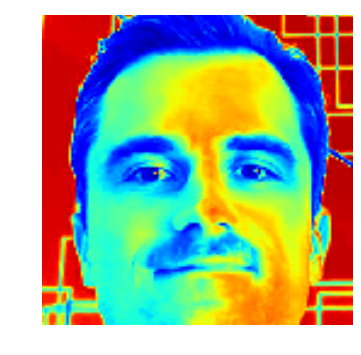

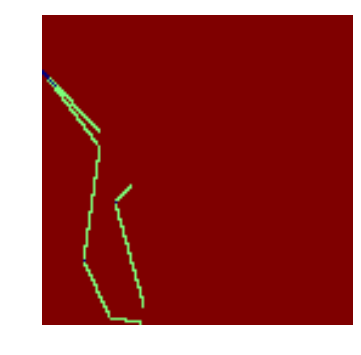

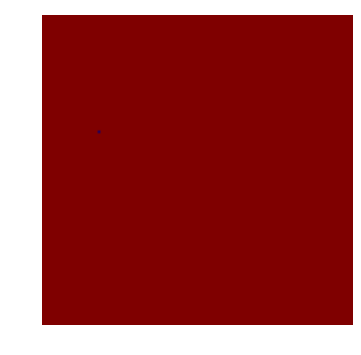

Brush at (23, 48)


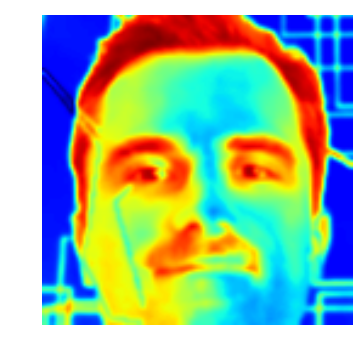

0.53737988498055245

In [232]:
#TESTING
a = Environment("images//test_face.png")
a.setBrushOpacity(0.25)
a.setRewardBlur(1)

for i in range(10):
    a.update( (random.randint(-50,50),random.randint(-50,50),1) )
    #a.showCanvas()
    #a.showBrush()

a.showAll()
a.getReward()

In [203]:
a.getState()

array([[[ 152.,  213.,  219., ...,  158.,  161.,  158.],
        [ 161.,  215.,  220., ...,  227.,  227.,  222.],
        [ 170.,  219.,  220., ...,  228.,  229.,  228.],
        ..., 
        [ 174.,  124.,  170., ...,  222.,  221.,  220.],
        [ 172.,  122.,  171., ...,  221.,  220.,  220.],
        [ 158.,  120.,  166., ...,  222.,  221.,  221.]],

       [[   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        ..., 
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.]],

       [[   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        ..., 
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0., 